Download books of two authors from the Gutenberg Project
Use HC scores to attribute each book to the corpus of its author.

Require packages 'gutenberg' and 'plotnine'

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import requests

#import auxiliary functions for python
import sys

import sys
sys.path.append('../')
from AuthAttLib import *
from visualize_HC_scores import *

%matplotlib inline
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers

<H1> Dicknes vs Austin </H1>

<H3>Download data from Gutenberg.org</H3>

In [90]:
Austin = [
('Jane Austin', 'Persuasion', "http://www.gutenberg.org/cache/epub/105/pg105.txt"),
('Jane Austin', 'Emma', "https://www.gutenberg.org/files/158/158-0.txt"),
('Jane Austin', 'Lady Susan', "http://www.gutenberg.org/cache/epub/946/pg946.txt"),
('Jane Austin', 'Mansfield Park', "https://www.gutenberg.org/files/141/141-0.txt"),
('Jane Austin', 'Northanger Abbey', "https://www.gutenberg.org/files/121/121-0.txt"),
('Jane Austin', 'Pride and Prejudice', "https://www.gutenberg.org/files/1342/1342-0.txt"),
('Jane Austin', 'Love and Friendship (Early Works)', "https://www.gutenberg.org/files/1212/1212-0.txt")
]
Dickens = [('Charles Dickens', 'American Notes', "https://www.gutenberg.org/files/675/675-0.txt"),
('Charles Dickens', 'Barnaby Rudge', "https://www.gutenberg.org/files/917/917-0.txt"),
('Charles Dickens', 'Children Stories', "http://www.gutenberg.org/cache/epub/37121/pg37121.txt"),
('Charles Dickens', 'The Battle of Life', "http://www.gutenberg.org/cache/epub/676/pg676.txt"),
('Charles Dickens', 'Bleak House', "http://www.gutenberg.org/cache/epub/1023/pg1023.txt"),
('Charles Dickens', 'David Copperfield', "https://www.gutenberg.org/files/766/766-0.txt"),
('Charles Dickens', 'Doctor Marigold', "http://www.gutenberg.org/cache/epub/1415/pg1415.txt"),
('Charles Dickens', 'Great Expectations', "https://www.gutenberg.org/files/1400/1400-0.txt"),
('Charles Dickens', 'Oliver Twist', "http://www.gutenberg.org/cache/epub/730/pg730.txt"),
('Charles Dickens', 'A Tale of Two Cities', 'https://www.gutenberg.org/files/98/98-0.txt'),
('Charles Dickens', 'A Chrismas Carol', 'https://www.gutenberg.org/files/46/46-0.txt'),
('Charles Dickens', 'Little Dorit', 'https://www.gutenberg.org/files/963/963-0.txt'),
('Charles Dickens', 'Hard Times', 'https://www.gutenberg.org/files/786/786-0.txt'),
('Charles Dickens', 'The Pickwick Papers', 'https://www.gutenberg.org/files/580/580-0.txt'),
('Charles Dickens', 'Our Mutual Friend', 'https://www.gutenberg.org/files/883/883-0.txt'),
('Charles Dickens', 'The Mufdog and Other Sketches', 'https://www.gutenberg.org/files/912/912-0.txt'),
('Charles Dickens', 'Nicholas Nickleby', 'https://www.gutenberg.org/files/967/967-0.txt'),
('Charles Dickens', 'The Old Curiosity Shop', 'https://www.gutenberg.org/files/700/700-0.txt'),
('Charles Dickens', 'A Child\'s History of England' , 'http://www.gutenberg.org/cache/epub/699/pg699.txt'),
('Charles Dickens', 'The Mystery of Edwin Drood', 'https://www.gutenberg.org/files/564/564-0.txt'),
('Charles Dickens', 'Martin Chuzzlewit', 'https://www.gutenberg.org/files/968/968-0.txt'),
('Charles Dickens', 'Sketches by Boz', 'https://www.gutenberg.org/files/882/882-0.txt'),
('Charles Dickens', 'Dombey and son', 'https://www.gutenberg.org/files/821/821-0.txt'),
('Charles Dickens', 'The Lamplighter', 'https://www.gutenberg.org/files/927/927-0.txt')
]
Bronte_sisters = [
    ('Charlotte', 'Villette', 'http://www.gutenberg.org/cache/epub/9182/pg9182.txt'),
    ('Charlotte', 'Shirley', 'https://www.gutenberg.org/files/30486/30486-0.txt'),
    ('Charlotte', 'The Professor', 'https://www.gutenberg.org/files/1028/1028-0.txt'),
    ('Charlotte', 'Jane Eyre', 'http://www.gutenberg.org/cache/epub/1260/pg1260.txt'),
    ('Anne', 'The Tenant of Wildfell Hall', 'https://www.gutenberg.org/files/969/969-0.txt'),
    ('Anne', 'Agnes Grey', 'https://www.gutenberg.org/files/767/767-0.txt'),
    ('Emily', 'Wuthering Heights', 'http://www.gutenberg.org/cache/epub/768/pg768.txt'),
    ('Anne/Charlotte/Emily', 'Poems', 'http://www.gutenberg.org/cache/epub/1019/pg1019.txt'),
]

def download_text(url) :    
    r = requests.get(url)
    if r.status_code == requests.codes.ok :
        txt = r.text.encode('UTF-8')
        return txt
    else:
        print('Failed')
        return ""

lo_lists = {'Austin' :  Austin, 
            'Dickens' : Dickens,
            'BronteSisters' : Bronte_sisters}
    
for ls in lo_lists :
    data = pd.DataFrame(lo_lists[ls], columns=['author', 'title', 'url'])
    data.loc[:,'text'] = data.url.apply(download_text)
    for r in data.iterrows() :
        print(" Downloaded {} by {} of length {} words".format(r[1].title,r[1].author, len(r[1].text.split())) )
    #    r.text.apply(lambda x : len(x.split())).mean()

    data.to_csv('./Data/' + str(ls) + '.csv')

 Downloaded Persuasion by Jane Austin of length 86307 words
 Downloaded Emma by Jane Austin of length 160458 words
 Downloaded Lady Susan by Jane Austin of length 26065 words
 Downloaded Mansfield Park by Jane Austin of length 162562 words
 Downloaded Northanger Abbey by Jane Austin of length 80158 words
 Downloaded Pride and Prejudice by Jane Austin of length 124592 words
 Downloaded Love and Friendship (Early Works) by Jane Austin of length 36295 words
 Downloaded American Notes by Charles Dickens of length 106399 words
 Downloaded Barnaby Rudge by Charles Dickens of length 256292 words
 Downloaded Children Stories by Charles Dickens of length 21954 words
 Downloaded The Battle of Life by Charles Dickens of length 32672 words
 Downloaded Bleak House by Charles Dickens of length 356466 words
 Downloaded David Copperfield by Charles Dickens of length 357847 words
 Downloaded Doctor Marigold by Charles Dickens of length 14909 words
 Downloaded Great Expectations by Charles Dickens of le

<H3> Prepare data, remove header, clean symbols and digits</H3>

In [4]:
from text_processing import *

def clean_corpus(data) :
    HEADER = 4000 # remove first 1000 characteres, usually contains header information
    data.text = data.text.apply(lambda x : x[HEADER:]) #trim header
    data.text = data.text.apply(remove_hexa_symbols)
    data.text = data.text.apply(remove_digits)
    data.text = data.text.apply(remove_CR_LF)
    data = data.filter(['author', 'title', 'text']).rename(columns = {'title' : 'doc_id'})
    return data

Dickens_corpus = pd.read_csv('../Data/Dickens.csv')
Austin_corpus = pd.read_csv('../Data/Austin.csv')

data = pd.concat([clean_corpus(Dickens_corpus),
                  clean_corpus(Austin_corpus)])

FileNotFoundError: [Errno 2] File b'../Data/Dickens.csv' does not exist: b'../Data/Dickens.csv'

<H3>Train Model</H3>

In [7]:
model = AuthorshipAttributionMulti(data,
                        vocab_size = 1000, # number of features
                        words_to_ignore = 
                    ['?','.',',',':',';','!','-','"','(',')'],
                        stbl = True, #mode of HC score
                        ngram_range = (1,1), # how many ngram to use
                        )

	 Creating author-model for Charles Dickens using 1000 features
		found 24 documents and 3554105 relevant tokens
	 Creating author-model for Jane Austin using 1000 features
		found 7 documents and 540758 relevant tokens


<H2>Compute and illustrate HC scores with respect to each author</H2>

100%|██████████| 2/2 [00:30<00:00, 16.62s/it]


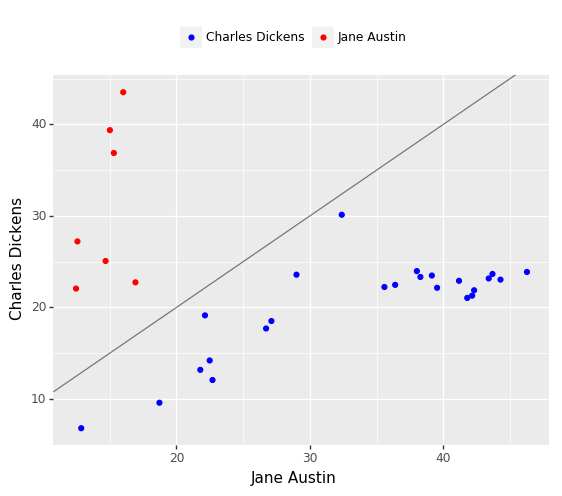

<ggplot: (-9223372036557686307)>

In [11]:
#compute HC scores of document against each corpus 
df0 = model.internal_stats_corpus()
df = model.internal_stats()
plot_author_pair(df, value = 'HC', wrt_authors=('Jane Austin', 'Charles Dickens'))

<H2>Find a set of distinguishing features. Reduce model to that set. </H2>

In [12]:
feat = model.reduce_features_from_model_pair('Charles Dickens', 'Jane Austin')
print(feat)

Reducting to 320 features
Changed vocabulary for Charles Dickens. Found 2119330 relevant tokens
Changed vocabulary for Jane Austin. Found 322339 relevant tokens
['the', 'and', 'to', 'a', 'in', 'that', 'he', 'his', 'was', 'with', 'her', 'had', 'for', 'mr', 'not', 'be', 'said', 'on', 'she', 'is', 'have', 'him', 'but', 'this', 'me', 'so', 'all', 'if', 'very', 'when', 'been', 'would', 'who', 'out', 'do', 'up', 'upon', 'little', 'could', 'more', 'mrs', 'into', 'man', 'any', 'will', 'sir', 'old', 'such', 'am', 'than', 'much', 'then', 'miss', 'down', 'well', 'being', 'should', 'here', 'like', 'himself', 'come', 'did', 'think', 'must', 'don', 'own', 'might', 'only', 'hand', 'head', 'these', 'where', 'nothing', 'without', 'night', 'gentleman', 'back', 'face', 'most', 'every', 'eyes', 'looked', 'door', 'though', 'looking', 'went', 'replied', 'shall', 'll', 'returned', 'always', 'through', 'took', 'why', 'put', 'father', 'round', 'herself', 'got', 'hands', 'indeed', 'give', 'name', 'soon', 'hope'

100%|██████████| 2/2 [00:14<00:00,  8.30s/it]


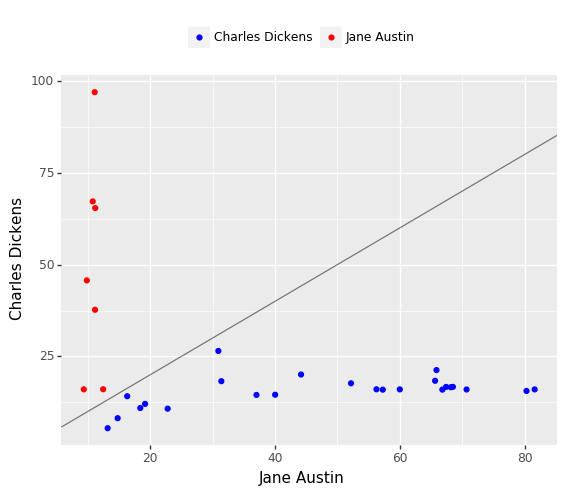

<ggplot: (-9223372036557692942)>

In [13]:
#compute HC scores of document against each corpus 
df = model.internal_stats()
plot_author_pair(df, value = 'HC', wrt_authors=('Jane Austin', 'Charles Dickens'))

<H1>Bronte Sisters</H1>

In [2]:
def clean_corpus(data) :
    HEADER = 1000
    data.text = data.text.apply(lambda x : x[HEADER:]) #trim header
    data = data.filter(['author', 'title', 'text']).rename(columns = {'title' : 'doc_id'})
    return data


Bronte_corpus = pd.read_csv('Bronte.csv')

data = clean_corpus(Bronte_corpus)

model = AuthorshipAttributionMultiText(data,
                        vocab_size = 1000,
                        words_to_ignore = [],
                        stbl = True,
                        ngram_range = (1,1),
                        )



	 Creating author-model for Charlotte
		found 4 documents, 1000 features, and 681754 relevant tokens
	 Creating author-model for Anne
		found 2 documents, 1000 features, and 296912 relevant tokens
	 Creating author-model for Emily
		found 1 documents, 1000 features, and 109817 relevant tokens
	 Creating author-model for Anne/Charlotte/Emily
		found 1 documents, 1000 features, and 31152 relevant tokens


100%|██████████| 4/4 [00:16<00:00,  4.14s/it]


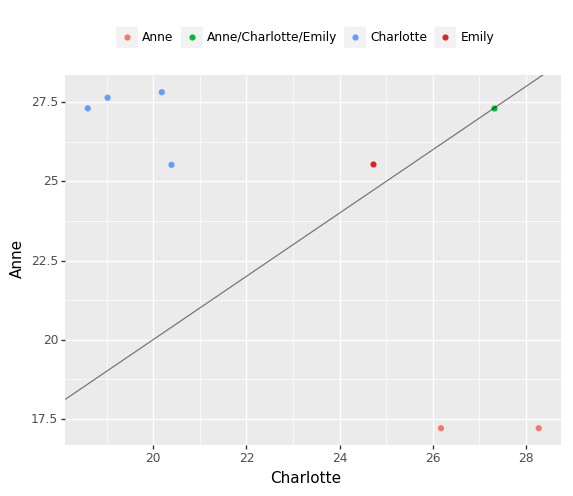

<ggplot: (-9223372036542853390)>

In [33]:
#compute HC scores of document against each corpus 
df0 = model.internal_stats_corpus()
df = model.internal_stats()

plot_author_pair(df, values='HC', wrt_authors=('Charlotte', 'Anne'))